In [346]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
#we need to load proper data sets
#all.csv contains all individual clusters
all_df = pd.read_csv('all.csv')

#my_e contains a list of clusters for which 
#I determined the energy using the developed approximation techniques
my_e = pd.read_csv('my_e.csv').drop(['Unnamed: 0','SCF_steps','magnetism',
                                     'time_of_calculation'],axis=1)
#clusters_phd.csv contains a bunch of clusters with precisely determined energy
#however, not all of the cases in this set were determined also by me
#the common part was included in the phd_common_part
#THIS DATASET has an energy predicted by me
phd_aprox = pd.read_csv('phd_common_part.csv').drop(['Unnamed: 0','SCF_steps','magnetism',
                                               'time_of_calculation'],axis=1)
#AND THIS DATASET has an energy calculated by phd_student
full_real_phd = pd.read_csv('clusters_phd.csv')[['full_notation','energy']]

### Data Extracting

In [347]:
#all of phd_aprox, my_e and full_real_phd do not contain any information that could be used by the model
#this information is in the all.csv file, so it must be extracted and assigned 
#to the appropriate rows in the mentioned data sets


def topology_to_list(imported_topology):
    topology = []
    for i in range(2,80,6):
        topology.append(imported_topology[i:i+2])        
    return topology

def extracting(df):
    #I want to load some information from all.csv
    
    #splitting "full_notation" column
    df = df.assign(number = df['full_notation'].apply(lambda x: x.split('_')[0]),
              joining_type = df['full_notation'].apply(lambda x: x.split('_')[1]),
              first_atom = df['full_notation'].apply(lambda x: x.split('_')[2]),
              second_atom = df['full_notation'].apply(lambda x: x.split('_')[3]),
            no_nickel = all_df['no_nickel'].apply(lambda x: x))
        
    df['no_nickel'], df['c_atom'],df['mass_center'],df['shortest_paths'] = None,None,None,None
    df['bonds'], df['conformation'], df['hydrogen'], df['topology'] = None, None, None, None
    df['type_of_first_atom'], df['type_of_second_atom'] = None,None
    df['energy_wth_h2'] = df['energy']
    
    for cluster in range(len(df)):
        for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
            df[column].iloc[cluster] = all_df[column].loc[int(df['number'].iloc[cluster])]
        for column in ['topology']:
            df[column].iloc[cluster] = topology_to_list(all_df[column].loc[int(df['number'].iloc[cluster])])
        df['hydrogen'].iloc[cluster] = 1 if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond','MC'] else 0
        if df['joining_type'].iloc[cluster] in ['MOCOM','MOCMHnbond','MC']:
            df['energy_wth_h2'].iloc[cluster] += 3.3831

    for cluster in range(len(df)):
        df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][int(df['first_atom'].iloc[cluster])]
        df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][int(df['second_atom'].iloc[cluster])]
    
    df = df.assign(ni_ncentre = df['shortest_paths'].apply(lambda x:x.split(',')[0][1:]),
              ni_centre = df['shortest_paths'].apply(lambda x:x.split(',')[1]),
               cu_ncentre = df['shortest_paths'].apply(lambda x:x.split(',')[2]),
                cu_centre = df['shortest_paths'].apply(lambda x:x.split(',')[3][:-1]),
                ni0 = df['conformation'].apply(lambda x: x.split(',')[0][1:]),
               ni8 = df['conformation'].apply(lambda x: x.split(',')[1]),
               ni17 = df['conformation'].apply(lambda x: x.split(',')[2]),
               ni25 = df['conformation'].apply(lambda x: x.split(',')[3]),
               ni33 = df['conformation'].apply(lambda x: x.split(',')[4]),
               ni42 = df['conformation'].apply(lambda x: x.split(',')[5]),
               ni50 = df['conformation'].apply(lambda x: x.split(',')[6][:-1]),
               nini = df['bonds'].apply(lambda x: x.split(',')[0][1:]),
               cucu = df['bonds'].apply(lambda x: x.split(',')[1]),
               nicu = df['bonds'].apply(lambda x: x.split(',')[2][:-1]))
    
    return df.drop(['shortest_paths','bonds','conformation','topology'],axis=1)
    
def energy_mix(df,column, hydrogen_correction=False,new_name='mix_energy'):
    #function that transcribe energy to mixed energy

    #first value is nickel energy, second is cooper
    if hydrogen_correction == False:
        monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                             'MOCOM':(-79.855113,-62.216739),
                                             'MOCMHnbond':(-79.004707,-61.301059),
                                             'MC':(-78.378661,-60.821898),
                                             'MOCM':(-75.478348,-57.428965)}
    #hydrogen corrections
    else:
        monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                             'MOCOM':(-79.855113+3.3831,-62.216739+3.3831),
                                             'MOCMHnbond':(-79.004707+3.3831,-61.301059+3.3831),
                                             'MC':(-78.378661+3.3831,-60.821898+3.3831),
                                             'MOCM':(-75.478348,-57.428965)}
    if column in df.columns and 'no_nickel' in df.columns and 'joining_type' in df.columns:
        print('Appriopiate columns are present in database')
        df[new_name] = None
        for i in range(len(df)):
            energy = df[column].iloc[i]
            nickel_part = monomet_cl_energy[df['joining_type'].iloc[i]][0]
            copper_part = monomet_cl_energy[df['joining_type'].iloc[i]][1]
            nickel = int(df['no_nickel'].iloc[i])           
            df[new_name].iloc[i] = (energy - (1/13)*(nickel*nickel_part + (13-nickel)*copper_part))
        return df
    else:
        print('Given database is missing at least one column')

def generating_full_db(df):
    final_df = energy_mix(extracting(df),'energy')
    final_df = energy_mix(final_df,'energy_wth_h2',hydrogen_correction=True,new_name='mix_energy_wth_h2')
    return final_df

### ML section

In [348]:
# thanks to above code I can generate good data sets by only one line

my_e = generating_full_db(my_e)
phd_aprox = generating_full_db(phd_aprox)
full_real_phd = generating_full_db(full_real_phd)

my_e = my_e[my_e['no_nickel'] <7]


Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database


### EDA

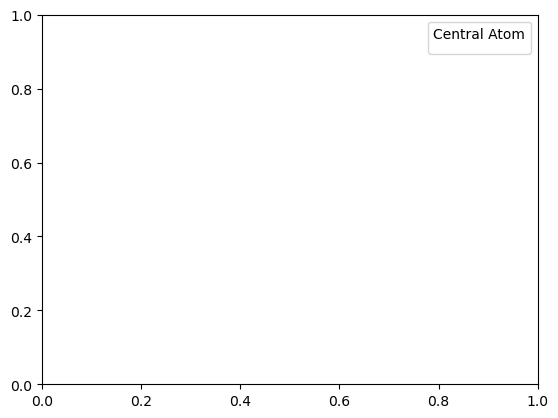

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

#g1 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="mix_energy", hue='c_atom')
#g1.set(xlabel='continous cases', ylabel = 'Normalize energy', xticklabels=[], title = 'Normalize energy for all cases')
#plt.legend(title='Central Atom', labels =['Cu','Ni'])
#plt.show()

#g2 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="mix_energy_wth_h2", hue='c_atom')
#g2.set(xlabel='continous cases', ylabel = 'Normalize energy', xticklabels=[], title = 'Normalize energy for all cases with hydrogen correction')
#plt.legend(title='Central Atom', labels =['Cu','Ni'])
#plt.show()

#g3 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="energy", hue='c_atom')
#g3.set(xlabel='continous cases', ylabel = 'Energy [eV]', xticklabels=[], title = 'Energy for all cases')
plt.legend(title='Central Atom', labels =['Cu','Ni'])
#plt.show()

#g4 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="energy_wth_h2", hue='c_atom')
#g4.set(xlabel='continous cases', ylabel = 'Energy [eV]', xticklabels=[], title = 'Energy for all cases with hydrogen correction')
#plt.legend(title='Central Atom', labels =['Cu','Ni'])
#plt.show()

In [350]:
fine_order = ['full_notation', 'energy','energy_wth_h2','mix_energy',
        'mix_energy_wth_h2', 'number', 'joining_type', 'first_atom',
       'second_atom', 'no_nickel', 'mass_center', 'hydrogen',        
       'ni_ncentre', 'ni_centre', 'cu_ncentre', 'cu_centre', 'ni0', 'ni8',
       'ni17', 'ni25', 'ni33', 'ni42', 'ni50', 'nini', 'cucu', 'nicu','c_atom',
        'type_of_first_atom', 'type_of_second_atom']

my_e = pd.DataFrame(data=my_e, columns = fine_order )

phd_aprox = pd.DataFrame(data=phd_aprox, columns =fine_order)

full_real_phd = pd.DataFrame(data=full_real_phd, columns = fine_order)


In [351]:
X = pd.get_dummies(data = my_e, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
#plt.subplots(figsize=(20,15))
X = X.drop(['full_notation','joining_type', 'number','first_atom','second_atom'],axis=1)
X = X.astype('float64')


#we can see that all the parameters related to the creation of a path after the cluster are highly correlated with each other so 
#I will leave the one most correlated with energy: cu_ncentre 

X= X.drop(['cu_centre','ni_centre','ni_ncentre'],axis=1)

#sns.heatmap(((X.corr()*100)**2)**0.5,annot=True,cmap='coolwarm')

#I have to do exaclty the same steps for phf ds as for my_e 

phd_aprox = pd.get_dummies(data = phd_aprox, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
phd_aprox = phd_aprox.drop(['full_notation','joining_type', 'number','first_atom','second_atom','cu_centre','ni_centre','ni_ncentre'],axis=1)
phd_aprox = phd_aprox.astype('float64')

full_real_phd = pd.get_dummies(data = full_real_phd, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
full_real_phd = full_real_phd.drop(['full_notation','joining_type', 'number','first_atom','second_atom','cu_centre','ni_centre','ni_ncentre'],axis=1)
full_real_phd = full_real_phd.astype('float64')


In [352]:
#let's normalize data

from sklearn.preprocessing import MinMaxScaler
X_norm = X.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1)
scaler = MinMaxScaler()
scaler.fit(X_norm)

X_norm = scaler.transform(X_norm)

phd_norm = scaler.transform(phd_aprox.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1))
full_real_phd_norm = scaler.transform(full_real_phd.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1))

full_real_phd_norm = pd.DataFrame(data = full_real_phd_norm, columns = full_real_phd.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1).columns)
phd_norm = pd.DataFrame(data = phd_norm, columns = phd_aprox.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1).columns)
X_norm = pd.DataFrame(data = X_norm, columns = X.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1).columns)


#let's now deal with outliers
import numpy as np
from scipy import stats

result = pd.concat([X_norm, X[['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2']].reset_index(drop=True)], axis=1)

val_phd_set = pd.concat([phd_norm, phd_aprox[['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2']].reset_index(drop=True)], axis=1)

val_full_real_phd = pd.concat([full_real_phd_norm.reset_index(drop=True), full_real_phd[['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2']].reset_index(drop=True)], axis=1)

#X_after_out = result[(np.abs(stats.zscore(result)) < 3).all(axis=1)]
X_after_out = result

#and create train and test data sets
from sklearn.model_selection import train_test_split

y = X_after_out['energy_wth_h2']
y = np.asarray(y).astype('float32')
X_norm = X_after_out.drop(['energy','energy_wth_h2','mix_energy','mix_energy_wth_h2'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size=0.3)

In [353]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from joblib import dump, load


def standard_accuracy(predicitons, real_data):

    avg_error = 0  
    for i in range(len(predicitons)):
        avg_error+= np.sqrt((predicitons[i]-real_data[i])**2)            
    avg_error /= len(predicitons)   

    return 1-(avg_error/(max(real_data)-min(real_data)))   

def entropy_accuracy(predicitons, real_data):
    
    val_df = pd.DataFrame(data=[predicitons,real_data]).transpose().sort_values(by=[0]).reset_index(names='reset').reset_index(names='pred').sort_values(by=[1]).reset_index(names='reset1').reset_index(names='real')

    entr = 0
    max_diff = 0
    for i in range(len(val_df)):
        diff = np.sqrt((val_df['pred'][i]-val_df['real'][i])**2)
        entr += diff
        if diff > max_diff:
            max_diff = diff
    return entr, max_diff


    
def svr(X_train,X_test,y_train,y_test, C_parameter = [0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,8,12,15,20], degrees = [x for x in range(1,8)], epsilon = [x/10 for x in range(1,12)], kernel = ['linear', 'poly', 'rbf', 'sigmoid'], accuracy='entropy'):
    
    best_acc = [0]
    for k in kernel:
        for C in C_parameter:
            for degree in degrees:
                for eps in epsilon:
                
                    model = SVR(C=C,degree = degree, epsilon = eps, kernel = k)
                    model.fit(X_train, y_train)
                    model_pred = model.predict(X_test)
                    
                    if accuracy == 'entropy':
                        acc = 1/entropy_accuracy(model_pred,y_test)[0]
                    else:
                        acc = standard_accuracy(model_pred, y_test)


                    if acc > best_acc[0]:
                        best_acc = [acc, 'max_diff:',entropy_accuracy(model_pred,y_test)[1], 'svr', 'C: ', C,'degree:', degree, 'eps:',eps, 'kernel:',k]
                        dump(model, 'model_svr.joblib') 
    print(best_acc) 
    
    return(best_acc, y_test, model_pred) 

def rf(X_train,X_test,y_train,y_test, estimators= [x* 25 for x in range(1,20)], min_samples_split = [x for x in range(2,7)], max_depth = [2,3,4,5,6,7,8,None], accuracy = 'entropy'):
    
    best_acc = [0]
    for min in min_samples_split:
        for est in estimators:
            for depth in max_depth:

                model = RandomForestRegressor(n_estimators=est, min_samples_split=min, max_depth=depth)  
                
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                if accuracy == 'entropy':
                    acc = 1/entropy_accuracy(model_pred,y_test)[0]
                else:
                    acc = standard_accuracy(model_pred, y_test)

                if acc > best_acc[0]:
                    best_acc = [acc, 'max_diff:',entropy_accuracy(model_pred,y_test)[1],'rf', 'est:' , est, 'minimum_sample_split:',min, 'max_depth',depth]
                    dump(model, 'model_rf.joblib') 
        
    print(best_acc) 
    
    return(best_acc, y_test, model_pred)

def etr(X_train,X_test,y_train,y_test, estimators= [x* 25 for x in range(1,20)],min_samples_split = [x for x in range(2,7)], max_depth = [2,3,4,5,6,7,8,None], accuracy = 'entropy'):
    
    best_acc = [0]
    for est in estimators:
        
        for min in min_samples_split:
            for depth in max_depth:
                model = ExtraTreesRegressor(n_estimators=est, min_samples_split=min, max_depth=depth)  
                
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                if accuracy == 'entropy':
                    acc = 1/entropy_accuracy(model_pred,y_test)[0]
                else:
                    acc = standard_accuracy(model_pred, y_test)
                        
                if acc > best_acc[0]:
                    best_acc = [acc, 'max_diff:',entropy_accuracy(model_pred,y_test)[1],'etr', 'est:' , est,'min_sample_split:',min, 'max_depth:',depth]
                    dump(model, 'model_etr.joblib') 
        
    print(best_acc) 
    
    return(best_acc, y_test, model_pred)

def gbt(X_train,X_test,y_train,y_test, estimators= [x* 25 for x in range(1,20)], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,8],min_samples_split = [x for x in range(2,6)], max_depth = [2,3,4,5,None], subsample = [x/10 for x in range(7,11)], loss_f = ['squared_error', 'absolute_error', 'huber', 'quantile'],accuracy = 'entropy'):
    
    best_acc = [0]
    for est in estimators:
        for l in lr:
            for min in min_samples_split:
                for subs in subsample:
                    for depth in max_depth:
                        for loss in loss_f:
                            model = GradientBoostingRegressor(n_estimators=est, learning_rate=l, min_samples_split=min, max_depth=depth, subsample=subs, loss=loss)  
                            
                            model.fit(X_train, y_train)
                            model_pred = model.predict(X_test)

                            if accuracy == 'entropy':
                                acc = 1/entropy_accuracy(model_pred,y_test)[1]
                            else:
                                acc = standard_accuracy(model_pred, y_test)
                                    
                            if acc > best_acc[0]:
                                best_acc = [acc, 'max_diff:',entropy_accuracy(model_pred,y_test)[1],'gbr', 'est:' , est, 'learning rate:',l,'min_sample_split:',min, 'max_depth:',depth, 'subsample:',subs, 'loss_f:',loss]
                                dump(model, 'model_gbt.joblib') 
        
            print(best_acc) 
    
    return(best_acc, y_test, model_pred)

def ada(X_train,X_test,y_train,y_test, estimators= [x*25 for x in range(1,20)], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,8], loss_f = ['linear', 'square', 'exponential'], accuracy = 'entropy'):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:  
            for loss in loss_f:
        
                model = AdaBoostRegressor(n_estimators=est, learning_rate=learning_rate, loss=loss)    
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                if accuracy == 'entropy':
                    acc = 1/entropy_accuracy(model_pred,y_test)[0]
                else:
                    acc = standard_accuracy(model_pred, y_test)
                
                if acc > best_acc[0]:
                    best_acc = [acc, 'max_diff:',entropy_accuracy(model_pred,y_test)[1],'ada',  'est:',est, 'learning rate:',learning_rate, 'loss:',loss]
                    dump(model, 'model_ada.joblib') 

    print(best_acc)       

    return(best_acc, y_test, model_pred)


#svr(X_train,X_test,y_train,y_test)
#ada(X_train,X_test,y_train,y_test)
#rf(X_train,X_test,y_train,y_test)
#etr(X_train,X_test,y_train,y_test)
#gbt(X_train,X_test,y_train,y_test)

print('ML done')

#t = entropy_accuracy(best_model.predict(X_test), y_test)
#t[0]


ML done


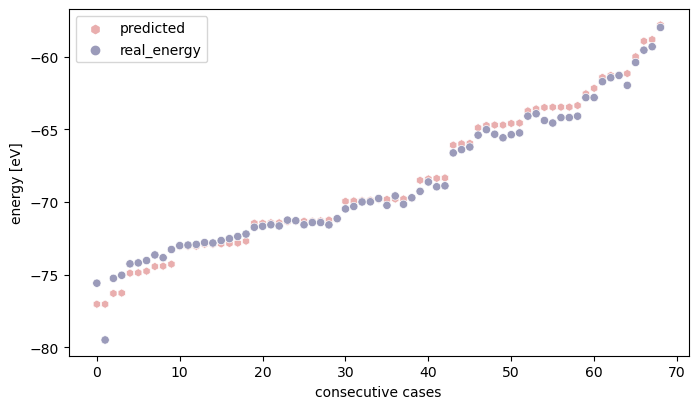

In [355]:
best_model = load('svr_normal_energy.joblib')

#validate = pd.DataFrame(data = [best_model.predict(X_test),y_test]).transpose()
#validate = pd.DataFrame(data = [best_model.predict(phd_norm),val_phd_set['mix_energy_wth_h2']]).transpose()
validate = pd.DataFrame(data = [best_model.predict(full_real_phd_norm),val_full_real_phd['energy_wth_h2']]).transpose()

validate = validate.rename(columns = {0:'predicted',1:'real_energy'})

colors = ['#e9aeae','#9b9bba']

sns.set_palette(sns.color_palette(colors))
markers = {'predicted': "h", 'real_energy': "o"}
plt.figure(figsize=(8,4.5))
ax = sns.scatterplot(data = validate.sort_values(by=['predicted']).reset_index(drop=True), markers=markers)
ax.set_xlabel("consecutive cases")
ax.set_ylabel("energy [eV]")
plt.show()

In [ ]:
entropy_accuracy(best_model.predict(full_real_phd_norm),val_full_real_phd['energy_wth_h2'])

(148.0, 9.0)